# <font color = '#e64626'>Assignment 1</font>


In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import geocoder
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set(style="white")
sns.set_context("notebook",
                rc={"xtick.labelsize": 12,
                    "ytick.labelsize": 12,
                    "axes.labelsize": 12,
                    "axes.titlesize": 15,
                    "legend.fontsize": 12})

# 1. 数据概述

In [3]:
A2B = pd.read_csv("A2B_Fare_Lookup.csv")
A2B.head()

,partitionKey,user_pseudo_id,createdAt,startAddress,endAddress,tripEstimate,BookingID,BookingCreatedTime,PickUp_Latitude,PickUp_Longitude,DropOff_Latitude,DropOff_Longitude,DispatchStatus
0,62988560-2b0f-11ed-aeba-d39c8d7719af,1546E396FBFD49E6ACCB9BCBA42DBFE7,2022-09-03 08:34:19.703,"2 Seaview Ave, Newport NSW 2106, Australia","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",126.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51064c10-2cea-11ed-9a00-d5b713a64e81,1546E396FBFD49E6ACCB9BCBA42DBFE7,2022-09-05 17:14:01.170,"181 Lawson St, Darlington NSW 2008, Australia","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",30.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,76a63b10-2dcb-11ed-9a00-d5b713a64e81,1546E396FBFD49E6ACCB9BCBA42DBFE7,2022-09-06 20:05:41.060,"17 Millman Rd, Spring Farm NSW 2570, Australia","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",158.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5b83c8b9-e7eb-479e-a7fa-4e9c2a110036,1546E396FBFD49E6ACCB9BCBA42DBFE7,2022-10-23 16:41:09.086,"6/73 Albert St, Revesby NSW 2212, Australia","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",68.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bb0e3a30-2e95-11ed-9a00-d5b713a64e81,1546E396FBFD49E6ACCB9BCBA42DBFE7,2022-09-07 20:13:34.166,"15 Warrigal St, Gregory Hills NSW 2557, Australia","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",160.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
A2B.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1153633 entries, 0 to 1153632
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   partitionKey        1153633 non-null  object 
 1   user_pseudo_id      1153633 non-null  object 
 2   createdAt           1153633 non-null  object 
 3   startAddress        1153415 non-null  object 
 4   endAddress          1153535 non-null  object 
 5   tripEstimate        1153633 non-null  float64
 6   BookingID           521373 non-null   float64
 7   BookingCreatedTime  521373 non-null   object 
 8   PickUp_Latitude     521373 non-null   float64
 9   PickUp_Longitude    521373 non-null   float64
 10  DropOff_Latitude    521371 non-null   float64
 11  DropOff_Longitude   521371 non-null   float64
 12  DispatchStatus      521373 non-null   object 
dtypes: float64(6), object(7)
memory usage: 114.4+ MB


In [5]:
raw = A2B

In [6]:
raw["DispatchStatus"].value_counts()

Completed       340009
NotCompleted    181364
Name: DispatchStatus, dtype: int64

# 2. 质量分析及数据预处理

## 2.1 去重

### 2.1.1 唯一字段去重

In [7]:
# 查看是否有全部重复的记录
raw.duplicated(keep=False).sum()

0

数据集中没有完全重复的记录。  
接下来对一些唯一字段进行查重，判断是否需要处理。
#### partitionKey

In [8]:
print("{:.2f}% duplicated records in partitionKey.".format(((len(raw) - raw["partitionKey"].nunique()) / len(raw) * 100)))

0.25% duplicated records in partitionKey.


用户预订出租车的流程大致为：  
1. 进入LookUp系统（获得唯一partitionKey）；  
2. 进入Booking系统（获得唯一BookingID）；  
3. 中止预订或完成预订。  

带有重复partitionKey的记录占比并不多，仅有0.25%。  通过观察，带有重复partitionKey的用户，都有多条不重复的BookingID，意味着用户可能在第一次进入booking后，退回了lookup阶段，但并未退出app，而是又发起了第二次booking（甚至第三、四次）。因此，partitionKey理论上也可以存在重复记录。  
然而，以上的情景仅为推测。若按照此逻辑推断，多次booking记录若按时间排序，则应该要么全部是未完成状态，要么只有最新一条记录是完成状态。而数据集中除开这两种情况外，还有其他的情景存在。

In [9]:
raw[raw.duplicated(subset=["partitionKey"], keep=False)].sort_values(by=["partitionKey","BookingCreatedTime"]).head(20)

,partitionKey,user_pseudo_id,createdAt,startAddress,endAddress,tripEstimate,BookingID,BookingCreatedTime,PickUp_Latitude,PickUp_Longitude,DropOff_Latitude,DropOff_Longitude,DispatchStatus
671353,000bafa0-2f6d-11ed-aeba-d39c8d7719af,EEEB8EA50CF946A383580FA06868EA7D,2022-09-08 21:54:31.706,"6 Canyon Rd, Baulkham Hills NSW 2153, Australia","3 Caledonia St, Paddington NSW 2021, Australia",117.50,31506625.0,2022-09-08 21:55:38.846,-33.766901,150.999133,-33.886285,151.232315,Completed
986147,000bafa0-2f6d-11ed-aeba-d39c8d7719af,EEEB8EA50CF946A383580FA06868EA7D,2022-09-08 21:54:31.706,"6 Canyon Rd, Baulkham Hills NSW 2153, Australia","3 Caledonia St, Paddington NSW 2021, Australia",117.50,31506628.0,2022-09-08 21:55:59.770,-33.766901,150.999133,-33.886285,151.232315,NotCompleted
980060,0024cd00-4f16-11ed-8cc4-f1bd638415f1,7B4D91163B174E27925EA76313763DA2,2022-10-19 05:52:22.866,"49-53 Ben Boyd Rd, Neutral Bay NSW 2089, Austr...","ATM 7409, Level 2, Sydney Domestic Airport T2,...",60.90,32437894.0,2022-10-19 05:56:04.786,-33.837923,151.217588,-33.933963,151.180537,NotCompleted
980059,0024cd00-4f16-11ed-8cc4-f1bd638415f1,7B4D91163B174E27925EA76313763DA2,2022-10-19 05:52:22.866,"49-53 Ben Boyd Rd, Neutral Bay NSW 2089, Austr...","ATM 7409, Level 2, Sydney Domestic Airport T2,...",60.90,32437898.0,2022-10-19 05:56:25.120,-33.837923,151.217588,-33.933963,151.180537,NotCompleted
896659,0056add0-4f97-11ed-9661-47dabcf94230,0881df095b1a6de4b06e97be0adc31b5,2022-10-19 21:15:48.270,"72 Park Ave, Kotara NSW 2289, Australia","17 Fowler St, Hamilton South NSW 2303, Australia",18.59,32457847.0,2022-10-19 21:16:07.230,-32.940391,151.711229,-32.935792,151.742417,Completed
1103082,0056add0-4f97-11ed-9661-47dabcf94230,0881df095b1a6de4b06e97be0adc31b5,2022-10-19 21:15:48.270,"72 Park Ave, Kotara NSW 2289, Australia","17 Fowler St, Hamilton South NSW 2303, Australia",18.59,32457850.0,2022-10-19 21:16:15.403,-32.940391,151.711229,-32.935792,151.742417,NotCompleted
1002248,00738720-46f0-11ed-9661-47dabcf94230,19d1af178252c65f698387af9778e32e,2022-10-08 21:00:13.203,"1427 Malvern Rd, Malvern VIC 3144, Australia","49 Luxmoore St, Cheltenham VIC 3192, Australia",46.41,32199112.0,2022-10-08 21:00:26.580,-37.853024,145.041855,-37.959602,145.047761,NotCompleted
710730,00738720-46f0-11ed-9661-47dabcf94230,19d1af178252c65f698387af9778e32e,2022-10-08 21:00:13.203,"1427 Malvern Rd, Malvern VIC 3144, Australia","49 Luxmoore St, Cheltenham VIC 3192, Australia",46.41,32199149.0,2022-10-08 21:02:14.166,-37.853024,145.041855,-37.959602,145.047761,Completed
681402,00934800-484c-11ed-9661-47dabcf94230,6050C2558FC645E7AE9D4CD93599EF28,2022-10-10 14:31:18.273,"25 Ocean View Ave, Airlie Beach QLD 4802, Aust...","1/370 Shute Harbour Rd, Airlie Beach QLD 4802,...",7.77,32234691.0,2022-10-10 14:31:52.346,-20.263768,148.716019,-20.269194,148.718982,Completed
683459,00934800-484c-11ed-9661-47dabcf94230,6050C2558FC645E7AE9D4CD93599EF28,2022-10-10 14:31:18.273,"25 Ocean View Ave, Airlie Beach QLD 4802, Aust...","1/370 Shute Harbour Rd, Airlie Beach QLD 4802,...",7.77,32234736.0,2022-10-10 14:34:00.246,-20.263768,148.716019,-20.269194,148.718982,Completed


In [10]:
idx = raw["partitionKey"].value_counts() > 1
partition_duplicated = pd.DataFrame(dict(Numbers=raw["partitionKey"].value_counts()[idx]))
partition_duplicated

,Numbers
bd3b05c0-51f6-11ed-8cc4-f1bd638415f1,8
18414ee0-584e-11ed-8b11-1f5b62fad19f,5
5fdbdce0-30e2-11ed-9992-2bb9650dd4cf,5
f392dde0-4149-11ed-8cc4-f1bd638415f1,5
d23e2580-2d82-11ed-aeba-d39c8d7719af,5
...,...
d453dfe0-35b6-11ed-9a00-d5b713a64e81,2
253aa540-300a-11ed-9a00-d5b713a64e81,2
72fdece0-3408-11ed-9a00-d5b713a64e81,2
eece6250-3bf6-11ed-9a00-d5b713a64e81,2


通过观察，数据集中patitionKey重复字段可分为以下几种情况：  
* 情况1：全部未完成
* 情况2：只有最后订单完成
* 情况3：超过一个订单完成
* 情况4：一个前序订单完成而其他订单未完成  

情况1&2符合用户的预订流程逻辑，故不做处理。情况3&4，并不符合用户使用app的流程逻辑，推测可能是系统问题导致，因此考虑直接删除对应partitionKey的全部记录。

In [11]:
subset = raw[raw.duplicated(subset=["partitionKey"], keep=False)].sort_values(by=["partitionKey","BookingCreatedTime"])[["partitionKey", "BookingCreatedTime", "DispatchStatus"]]
subset

,partitionKey,BookingCreatedTime,DispatchStatus
671353,000bafa0-2f6d-11ed-aeba-d39c8d7719af,2022-09-08 21:55:38.846,Completed
986147,000bafa0-2f6d-11ed-aeba-d39c8d7719af,2022-09-08 21:55:59.770,NotCompleted
980060,0024cd00-4f16-11ed-8cc4-f1bd638415f1,2022-10-19 05:56:04.786,NotCompleted
980059,0024cd00-4f16-11ed-8cc4-f1bd638415f1,2022-10-19 05:56:25.120,NotCompleted
896659,0056add0-4f97-11ed-9661-47dabcf94230,2022-10-19 21:16:07.230,Completed
...,...,...,...
1074651,ffd59e90-404e-11ed-8cc4-f1bd638415f1,2022-09-30 09:32:55.196,NotCompleted
764322,ffe10800-4145-11ed-9661-47dabcf94230,2022-10-01 15:00:58.350,Completed
764323,ffe10800-4145-11ed-9661-47dabcf94230,2022-10-01 15:01:02.623,Completed
978885,fffde800-3c25-11ed-9a00-d5b713a64e81,2022-09-25 02:29:52.510,NotCompleted


In [12]:
for key in partition_duplicated.index:
    temp = subset[subset["partitionKey"] == key]
    if len(temp) - temp["DispatchStatus"].str.contains("NotCompleted").sum() == 0:  # 情景1
        partition_duplicated.loc[key, "Scenario"] = 1
    elif len(temp) - temp["DispatchStatus"].str.contains("NotCompleted").sum() == 1 and temp["DispatchStatus"].values[-1] == "Completed":  # 情景2
        partition_duplicated.loc[key, "Scenario"] = 2
    elif len(temp) - temp["DispatchStatus"].str.contains("NotCompleted").sum() > 1:  # 情景3
        partition_duplicated.loc[key, "Scenario"] = 3
    elif temp["DispatchStatus"].values[-1] == "NotCompleted" and len(temp) - temp["DispatchStatus"].str.contains("NotComplete").sum() != 0:  # 情景4
        partition_duplicated.loc[key, "Scenario"] = 4

In [13]:
len(partition_duplicated) - partition_duplicated["Scenario"].notnull().sum()

0

In [14]:
partition_duplicated["Scenario"].value_counts().sort_index()

1.0    1028
2.0     946
3.0     200
4.0     530
Name: Scenario, dtype: int64

In [15]:
partition_duplicated

,Numbers,Scenario
bd3b05c0-51f6-11ed-8cc4-f1bd638415f1,8,1.0
18414ee0-584e-11ed-8b11-1f5b62fad19f,5,1.0
5fdbdce0-30e2-11ed-9992-2bb9650dd4cf,5,4.0
f392dde0-4149-11ed-8cc4-f1bd638415f1,5,4.0
d23e2580-2d82-11ed-aeba-d39c8d7719af,5,2.0
...,...,...
d453dfe0-35b6-11ed-9a00-d5b713a64e81,2,2.0
253aa540-300a-11ed-9a00-d5b713a64e81,2,4.0
72fdece0-3408-11ed-9a00-d5b713a64e81,2,2.0
eece6250-3bf6-11ed-9a00-d5b713a64e81,2,2.0


In [16]:
dropindex = raw["partitionKey"].isin(partition_duplicated[(partition_duplicated["Scenario"]==3) | (partition_duplicated["Scenario"]==4)].index.values)
raw = raw[~dropindex]

In [17]:
raw.head()

,partitionKey,user_pseudo_id,createdAt,startAddress,endAddress,tripEstimate,BookingID,BookingCreatedTime,PickUp_Latitude,PickUp_Longitude,DropOff_Latitude,DropOff_Longitude,DispatchStatus
0,62988560-2b0f-11ed-aeba-d39c8d7719af,1546E396FBFD49E6ACCB9BCBA42DBFE7,2022-09-03 08:34:19.703,"2 Seaview Ave, Newport NSW 2106, Australia","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",126.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51064c10-2cea-11ed-9a00-d5b713a64e81,1546E396FBFD49E6ACCB9BCBA42DBFE7,2022-09-05 17:14:01.170,"181 Lawson St, Darlington NSW 2008, Australia","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",30.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,76a63b10-2dcb-11ed-9a00-d5b713a64e81,1546E396FBFD49E6ACCB9BCBA42DBFE7,2022-09-06 20:05:41.060,"17 Millman Rd, Spring Farm NSW 2570, Australia","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",158.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5b83c8b9-e7eb-479e-a7fa-4e9c2a110036,1546E396FBFD49E6ACCB9BCBA42DBFE7,2022-10-23 16:41:09.086,"6/73 Albert St, Revesby NSW 2212, Australia","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",68.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bb0e3a30-2e95-11ed-9a00-d5b713a64e81,1546E396FBFD49E6ACCB9BCBA42DBFE7,2022-09-07 20:13:34.166,"15 Warrigal St, Gregory Hills NSW 2557, Australia","Sydney Airport DOM T2 Drop-Off, Sydney Airport...",160.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### BookingID
BookingID没有任何重复记录。

In [18]:
bks = raw[raw["BookingID"].notnull()]
len(bks)  == bks["BookingID"].nunique()

True

### 2.1.2 逻辑判断去重
在唯一字段的检验中，我们已经剔除了不符合流程逻辑的partitionKey重复记录，并保留了符合逻辑且反应现实的重复记录。但是基于观察，我们不难发现数据集中还存在一些其他不符合逻辑的重复记录，这些记录通过对单一的唯一字段进行检验无法找出，需要多变量联合筛选。  
具体来说，尽管从全数据集来看，LookUp时间和Booking时间是可以重复的字段。但是对于同一个用户来说，在同一时间进行多次查询或预订显然是不符合逻辑的。因此在此部分中，我们考虑将用户id和两个时间字段进行交叉检验，并对存在逻辑问题的记录进行清理。

#### user_pseudo_id & createdAt
通过筛选，将同一用户、同一时间但却有不重复partitionKey的记录挑选出来，一共24条。显然，同一用户不可能在完全相同的时间里提出多次不同（partitionKey不同）的lookup请求，因此考虑将重复记录删除，保留一条记录。若有booking记录，则保留带有booking的记录。

In [19]:
# 查看同一用户同一时间有LookUp记录的数量
temp = raw[raw.duplicated(subset=["user_pseudo_id", "createdAt"], keep=False)].sort_values(by=["user_pseudo_id"])  # 选出同一用户同一时间的LookUp记录
key = temp["partitionKey"].value_counts()[temp["partitionKey"].value_counts() == 1].index.values  # 其中有一部分是重复partitionKey的记录，已在上面完成处理，找出不带有重复partitionKey的记录的key
idx = temp["partitionKey"].isin(key)
temp = temp[idx].sort_values(by=["user_pseudo_id","BookingID"])
# 一共有24条记录

In [20]:
temp

,partitionKey,user_pseudo_id,createdAt,startAddress,endAddress,tripEstimate,BookingID,BookingCreatedTime,PickUp_Latitude,PickUp_Longitude,DropOff_Latitude,DropOff_Longitude,DispatchStatus
302517,1f702ef0-2fe7-11ed-aeba-d39c8d7719af,0295699BB96C4A10B921DC0671C726BE,2022-09-09 12:28:42.973,"Domestic Airport Station, Mascot NSW 2020, Aus...","38 Chesterfield Parade, Bronte NSW 2024, Austr...",41.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
302337,1f702ef0-2fe7-11ed-9a00-d5b713a64e81,0295699BB96C4A10B921DC0671C726BE,2022-09-09 12:28:42.973,"Domestic Airport Station, Mascot NSW 2020, Aus...","38 Chesterfield Parade, Bronte NSW 2024, Austr...",41.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357284,4a73a540-4dac-11ed-9661-47dabcf94230,0E9EDF31EB204423BB9FA63D783FC868,2022-10-17 10:43:09.716,"4 Mesa Link, Baldivis WA 6171, Australia","21 Enterprise Way, Rockingham WA 6168, Australia",37.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357193,4a735720-4dac-11ed-8cc4-f1bd638415f1,0E9EDF31EB204423BB9FA63D783FC868,2022-10-17 10:43:09.716,"4 Mesa Link, Baldivis WA 6171, Australia","21 Enterprise Way, Rockingham WA 6168, Australia",37.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218292,7c906290-421f-11ed-9661-47dabcf94230,2E80FAA2D2854929AE1C2BDB9F108F63,2022-10-02 17:57:31.963,"32 Timbertop Mead, Burleigh Heads QLD 4220, Au...","12 Walton St, Southport QLD 4215, Australia",58.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218491,7c90d7c0-421f-11ed-8cc4-f1bd638415f1,2E80FAA2D2854929AE1C2BDB9F108F63,2022-10-02 17:57:31.963,"32 Timbertop Mead, Burleigh Heads QLD 4220, Au...","12 Walton St, Southport QLD 4215, Australia",58.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318066,6054f7f0-5596-11ed-bafc-eb69a13397eb,5209AF53D3F64097B466EDDB77EB0BEE,2022-10-27 12:26:26.800,"Cnr Sayers Rd &, Forsyth Rd, Williams Landing ...","21 Export Dr, Brooklyn VIC 3012, Australia",42.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
317751,6054f7f3-5596-11ed-bafc-eb69a13397eb,5209AF53D3F64097B466EDDB77EB0BEE,2022-10-27 12:26:26.800,"Cnr Sayers Rd &, Forsyth Rd, Williams Landing ...","21 Export Dr, Brooklyn VIC 3012, Australia",42.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
397344,7315b5d0-3af3-4d74-bc8e-aba9d365a692,7B195F2F25E442D58C755696287370B4,2022-10-26 20:28:54.446,"2 Weeroona Ave, Bendigo VIC 3550, Australia","7 Rathbones Ln, Maiden Gully VIC 3551, Australia",32.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
397462,ff5a0236-c955-40fd-9149-472d2d13a0f4,7B195F2F25E442D58C755696287370B4,2022-10-26 20:28:54.446,"2 Weeroona Ave, Bendigo VIC 3550, Australia","7 Rathbones Ln, Maiden Gully VIC 3551, Australia",32.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
keep = temp.drop_duplicates(subset=["createdAt"], inplace=False, keep="first").index  # 首先选出在数据集里要留下的index
drop = [idx for idx in temp.index]  # 用for循环把重复集中要剔除的index选出来
for idx in drop:
    if idx in keep:
        drop.remove(idx)
drop

[302337,
 357193,
 218491,
 317751,
 397462,
 466297,
 175468,
 504459,
 446079,
 226258,
 426805,
 591485]

In [22]:
raw.drop(drop, axis=0,inplace=True)

In [23]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152083 entries, 0 to 1153632
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   partitionKey        1152083 non-null  object 
 1   user_pseudo_id      1152083 non-null  object 
 2   createdAt           1152083 non-null  object 
 3   startAddress        1151865 non-null  object 
 4   endAddress          1151985 non-null  object 
 5   tripEstimate        1152083 non-null  float64
 6   BookingID           519835 non-null   float64
 7   BookingCreatedTime  519835 non-null   object 
 8   PickUp_Latitude     519835 non-null   float64
 9   PickUp_Longitude    519835 non-null   float64
 10  DropOff_Latitude    519833 non-null   float64
 11  DropOff_Longitude   519833 non-null   float64
 12  DispatchStatus      519835 non-null   object 
dtypes: float64(6), object(7)
memory usage: 123.1+ MB


#### user_pseudo_id & BookingCreatedTime
BookingCreatedTime没有不合逻辑的重复值，说明booking子集的数据质量较好。

In [24]:
bks = raw[raw["BookingID"].notnull()]  # 选出booking子集
len(bks[bks.duplicated(subset=["user_pseudo_id", "BookingCreatedTime"], keep=False)].sort_values(by=["user_pseudo_id"]))

0

## 2.2 缺失值处理

首先将数据集分为两个子集：查询集（lk_subset）和预订集（bk_subset）。显然，按照流程逻辑，查询集中BookingID及其后序字段均为NAN，而预订集中所有字段应都有对应的值。

In [25]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152083 entries, 0 to 1153632
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   partitionKey        1152083 non-null  object 
 1   user_pseudo_id      1152083 non-null  object 
 2   createdAt           1152083 non-null  object 
 3   startAddress        1151865 non-null  object 
 4   endAddress          1151985 non-null  object 
 5   tripEstimate        1152083 non-null  float64
 6   BookingID           519835 non-null   float64
 7   BookingCreatedTime  519835 non-null   object 
 8   PickUp_Latitude     519835 non-null   float64
 9   PickUp_Longitude    519835 non-null   float64
 10  DropOff_Latitude    519833 non-null   float64
 11  DropOff_Longitude   519833 non-null   float64
 12  DispatchStatus      519835 non-null   object 
dtypes: float64(6), object(7)
memory usage: 123.1+ MB


In [26]:
bk_subset = raw[raw["BookingID"].notnull()]
lk_subset = raw[raw["BookingID"].isnull()]
len(bk_subset) + len(lk_subset) == len(raw)

True

### 2.2.1 查询集（LookUp Subset）

In [27]:
lk_subset.isnull().sum()

partitionKey               0
user_pseudo_id             0
createdAt                  0
startAddress             114
endAddress                48
tripEstimate               0
BookingID             632248
BookingCreatedTime    632248
PickUp_Latitude       632248
PickUp_Longitude      632248
DropOff_Latitude      632248
DropOff_Longitude     632248
DispatchStatus        632248
dtype: int64

In [28]:
# 两集元素数量相加和两集并集的元素数量相等，所以起始点缺失和终点缺失互不重合
len(lk_subset[lk_subset["startAddress"].isnull() | lk_subset["endAddress"].isnull()]) == len(lk_subset[lk_subset["startAddress"].isnull()])+len(lk_subset[lk_subset["endAddress"].isnull()])

True

In [29]:
lk_subset[lk_subset["user_pseudo_id"]=="E447773A9F2B4902B8379C2C5D285B75"].sort_values("createdAt")

,partitionKey,user_pseudo_id,createdAt,startAddress,endAddress,tripEstimate,BookingID,BookingCreatedTime,PickUp_Latitude,PickUp_Longitude,DropOff_Latitude,DropOff_Longitude,DispatchStatus
579880,28d55780-3fc9-11ed-9a00-d5b713a64e81,E447773A9F2B4902B8379C2C5D285B75,2022-09-29 17:34:32.440,"585-589 Princes Hwy, Noble Park VIC 3174, Aust...","801 Princes Hwy, Springvale VIC 3171, Australia",18.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN
346222,89be8920-439f-11ed-8cc4-f1bd638415f1,E447773A9F2B4902B8379C2C5D285B75,2022-10-04 15:46:40.820,"GROUND FLOOR, 2107/2125 Princes Hwy, Clayton V...","15 State Route 19, Caulfield North VIC 3161, A...",37.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
565603,7b0e64d0-4440-11ed-8cc4-f1bd638415f1,E447773A9F2B4902B8379C2C5D285B75,2022-10-05 10:58:45.150,"15 Hawthorn Rd, Caulfield North VIC 3161, Aust...","23A Izett St, Prahran VIC 3181, Australia",20.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594705,b4d976c0-45d3-11ed-9661-47dabcf94230,E447773A9F2B4902B8379C2C5D285B75,2022-10-07 11:05:09.293,"15 State Route 19, Caulfield North VIC 3161, A...","13 Izett St, Prahran VIC 3181, Australia",21.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
398882,e98e4f70-464c-11ed-9661-47dabcf94230,E447773A9F2B4902B8379C2C5D285B75,2022-10-08 01:32:46.823,"49-Arthur St/Hawthorn Rd, Caulfield North VIC ...","15 State Route 19, Caulfield North VIC 3161, A...",11.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225149,f0880be0-464c-11ed-9661-47dabcf94230,E447773A9F2B4902B8379C2C5D285B75,2022-10-08 01:32:58.526,"15 State Route 19, Caulfield North VIC 3161, A...","10 Keech Cl, Noble Park North VIC 3174, Australia",62.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
494888,7d95ec20-4687-11ed-8cc4-f1bd638415f1,E447773A9F2B4902B8379C2C5D285B75,2022-10-08 08:32:05.986,"15 State Route 19, Caulfield North VIC 3161, A...","13 Izett St, Prahran VIC 3181, Australia",22.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458829,d4064740-4b0e-11ed-9661-47dabcf94230,E447773A9F2B4902B8379C2C5D285B75,2022-10-14 02:50:57.716,"840 Princes Hwy Service Rd, Caulfield East VIC...","484 Malvern Rd, Prahran VIC 3181, Australia",25.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597196,c26d25e0-4b85-11ed-9661-47dabcf94230,E447773A9F2B4902B8379C2C5D285B75,2022-10-14 17:02:18.303,NaN,"15 State Route 19, Caulfield North VIC 3161, A...",16.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
565983,bad24250-4d44-11ed-8cc4-f1bd638415f1,E447773A9F2B4902B8379C2C5D285B75,2022-10-16 22:21:50.583,"27 Devira St, Dandenong North VIC 3175, Australia","10 Keech Cl, Noble Park North VIC 3174, Australia",20.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
drop = lk_subset[lk_subset["startAddress"].isnull() | lk_subset["endAddress"].isnull()].index

In [31]:
raw.drop(drop, axis=0, inplace=True)

In [32]:
raw[raw["BookingID"].isnull()].isnull().sum()

partitionKey               0
user_pseudo_id             0
createdAt                  0
startAddress               0
endAddress                 0
tripEstimate               0
BookingID             632086
BookingCreatedTime    632086
PickUp_Latitude       632086
PickUp_Longitude      632086
DropOff_Latitude      632086
DropOff_Longitude     632086
DispatchStatus        632086
dtype: int64

### 2.2.2 预订集（Booking Subset）

In [33]:
bk_subset.isnull().sum()

partitionKey            0
user_pseudo_id          0
createdAt               0
startAddress          104
endAddress             50
tripEstimate            0
BookingID               0
BookingCreatedTime      0
PickUp_Latitude         0
PickUp_Longitude        0
DropOff_Latitude        2
DropOff_Longitude       2
DispatchStatus          0
dtype: int64

#### DropOff Lat & Long
先看经纬度缺失

In [34]:
dropoff = bk_subset[bk_subset["DropOff_Latitude"].isnull() | bk_subset["DropOff_Longitude"].isnull()]
dropoff

,partitionKey,user_pseudo_id,createdAt,startAddress,endAddress,tripEstimate,BookingID,BookingCreatedTime,PickUp_Latitude,PickUp_Longitude,DropOff_Latitude,DropOff_Longitude,DispatchStatus
866815,b5d2440e-01c6-49c9-a3d3-4c4b96ff219c,5294f665d8dc60866199af8d6668b748,2022-10-27 09:15:40.266,"105 Cape St, Heidelberg VIC 3084, Australia","27 Perth St, Heidelberg West VIC 3081, Australia",19.53,32644086.0,2022-10-27 09:15:46.640,-37.755553,145.066975,NaN,NaN,Completed
943894,8389bde0-3b9d-11ed-9a00-d5b713a64e81,135E9F3B2E7146BC8BEC8DA1BD450F08,2022-09-24 10:12:02.110,"723 State Route 15, Malvern East VIC 3145, Aus...","8 Warner Ave, Ashburton VIC 3147, Australia",14.91,31859589.0,2022-09-24 10:12:13.406,-37.881228,145.090564,NaN,NaN,Completed


因为有终点地址，可以对dropoff经纬度进行填补。

In [35]:
g = geocoder.arcgis("27 Perth St, Heidelberg West VIC 3081, Australia")
g.latlng

[-37.73524201369623, 145.04198174227122]

In [36]:
for idx in dropoff.index:
    endaddress = raw.loc[idx, "endAddress"]
    g = geocoder.arcgis(endaddress)
    lat, long = g.latlng[0], g.latlng[1]
    raw.loc[idx, "DropOff_Latitude"], raw.loc[idx,"DropOff_Longitude"] = lat, long

In [37]:
raw[raw["BookingID"].notnull()].isnull().sum()

partitionKey            0
user_pseudo_id          0
createdAt               0
startAddress          104
endAddress             50
tripEstimate            0
BookingID               0
BookingCreatedTime      0
PickUp_Latitude         0
PickUp_Longitude        0
DropOff_Latitude        0
DropOff_Longitude       0
DispatchStatus          0
dtype: int64

#### startAddress & enAddress
接下来对这两个字段的缺失值用记录中的经纬度进行逆编码填补。

In [38]:
address_null_subset = bk_subset[bk_subset["startAddress"].isnull() | bk_subset["endAddress"].isnull()]
address_null_subset[['startAddress','endAddress']]=address_null_subset[['startAddress','endAddress']].astype(str)  # 将字段中的NAN转变成字符串nan，便于后续提取
address_null_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 632260 to 1148206
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   partitionKey        154 non-null    object 
 1   user_pseudo_id      154 non-null    object 
 2   createdAt           154 non-null    object 
 3   startAddress        154 non-null    object 
 4   endAddress          154 non-null    object 
 5   tripEstimate        154 non-null    float64
 6   BookingID           154 non-null    float64
 7   BookingCreatedTime  154 non-null    object 
 8   PickUp_Latitude     154 non-null    float64
 9   PickUp_Longitude    154 non-null    float64
 10  DropOff_Latitude    154 non-null    float64
 11  DropOff_Longitude   154 non-null    float64
 12  DispatchStatus      154 non-null    object 
dtypes: float64(6), object(7)
memory usage: 16.8+ KB


In [39]:
for idx in address_null_subset.index:
    if (address_null_subset.loc[idx, 'startAddress']) == 'nan':
        g = geocoder.osm(address_null_subset.loc[idx, ['PickUp_Latitude', 'PickUp_Longitude']].to_list(), method='reverse')
        raw.loc[idx, 'startAddress'] = g.address
    else:
        g = geocoder.osm(address_null_subset.loc[idx, ['DropOff_Latitude', 'DropOff_Longitude']].to_list(), method='reverse')
        raw.loc[idx, 'endAddress'] = g.address

In [40]:
raw[raw["BookingID"].notnull()].isnull().sum()

partitionKey          0
user_pseudo_id        0
createdAt             0
startAddress          0
endAddress            0
tripEstimate          0
BookingID             0
BookingCreatedTime    0
PickUp_Latitude       0
PickUp_Longitude      0
DropOff_Latitude      0
DropOff_Longitude     0
DispatchStatus        0
dtype: int64

至此完成数据清洗工作。

In [41]:
washed = raw  # 给清洗后的df重新命名为washed
whole = washed.copy()  # 对washed进行复制，保留一份副本，之后的特征工程在whole df上进行
whole.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151921 entries, 0 to 1153632
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   partitionKey        1151921 non-null  object 
 1   user_pseudo_id      1151921 non-null  object 
 2   createdAt           1151921 non-null  object 
 3   startAddress        1151921 non-null  object 
 4   endAddress          1151921 non-null  object 
 5   tripEstimate        1151921 non-null  float64
 6   BookingID           519835 non-null   float64
 7   BookingCreatedTime  519835 non-null   object 
 8   PickUp_Latitude     519835 non-null   float64
 9   PickUp_Longitude    519835 non-null   float64
 10  DropOff_Latitude    519835 non-null   float64
 11  DropOff_Longitude   519835 non-null   float64
 12  DispatchStatus      519835 non-null   object 
dtypes: float64(6), object(7)
memory usage: 155.3+ MB


# 3. 特征工程 & EDA

## 3.1 地址类

In [42]:
# start_dict = {
#     "NSW": "NSW",
#     "QLD": "QLD",
#     "VIC": "VIC",
#     "WA": "WA",
#     "SA": "SA",
#     "TAS": "TAS",
#     "ACT": "ACT",
#     "NT": "NT",
    
    
#     "New South Wales": "NSW",
#     "Queensland": "QLD",
#     "Western Australia": "WA",
#     "Northern Territory": "NT",
#     "Tasmania": "TAS",
#     "Victoria": "VIC",
#     "South Australia": "SA",
    
#     "Gold Coast": "QLD",
#     "Nelly Bay": "QLD",
#     "Shute Harbour": "QLD",
#     "Sea World": "QLD",
#     "Redland": "QLD",
#     "Great Barrier": "QLD",
#     "Coral Sea": "QLD",
   
    
#     "RIVER BOULEVARD RICHMOND": "VIC",
#     "William St/Collins": "VIC",

# }
# whole["StartState"] = None
# for key in start_dict.keys():
#     whole.loc[whole["startAddress"].str.contains(key) & whole["StartState"].isnull(), "StartState"] = start_dict[key]

In [43]:
# start_dict = {
#     "NSW": ["NSW", "New South Wales"],
#     "QLD": ["QLD", "Queensland", "Gold Coast", "Nelly Bay", "Shute Harbour", "Sea World", "Redland"],
#     "SA": ["SA", "South Australia"],
#     "TAS": ["TAS", "Tasmania"],
#     "VIC": ["VIC", "RIVER BOULEVARD RICHMOND", "William St/Collins", "Victoria"],
#     "WA": ["WA", "Western Australia"],
#     "ACT": ["ACT"],
#     "NT": ["NT", "Northern Territory"],
#     "Coral Sea": ["Coral", "Great Barrier"]
# }
# for key in start_dict.keys():
#     for item in start_dict.get(key):
#         whole.loc[whole["startAddress"].str.contains(item), "StartState"] = key

In [44]:
# end_dict = {
#     "NSW": "NSW",
#     "QLD": "QLD",
#     "VIC": "VIC",
#     "WA": "WA",
#     "SA": "SA",
#     "TAS": "TAS",
#     "NT": "NT",
#     "ACT": "ACT", 

    
    
#     "New South Wales": "NSW",
#     "Queensland": "QLD",
#     "South Australia": "SA",
#     "Tasmania": "TAS",
#     "Victoria": "VIC",
#     "Northern Territory": "NT",
#     "Australian Capital Territory": "ACT",
#     "Western Australia": "WA",
    
    
    
#     "Canberra": "ACT",
#     "St Kilda Marina": "VIC",
#     "Gold Coast": "QLD",
#     "Terminal, Bilinga": "QLD",
#     "Tea Tree Bay": "QLD",
#     "Nelly Bay": "QLD",
#     "Shute Harbour": "QLD",
#     "Sea World": "QLD",
#     "Coral": "QLD",
#     "Great Barrier": "QLD",
#     "Redland": "QLD",
#     "Fitzwilliam St": "NSW",
#     "Byron Bay": "NSW",  

# }
# whole["EndState"] = None

# for key in end_dict.keys():
#     whole.loc[whole["endAddress"].str.contains(key) & whole["EndState"].isnull(), "EndState"] = end_dict[key]

In [ ]:
# end_dict = {
#     "NSW": ["NSW", "New South Wales", "Fitzwilliam St", "Byron Bay"],
#     "QLD": ["QLD", "Queensland", "Gold Coast", "Terminal, Bilinga", "Tea Tree Bay", "Nelly Bay", "Shute Harbour", "Sea World", "Redland"],
#     "SA": ["SA", "South Australia"],
#     "TAS": ["TAS", "Tasmania"],
#     "VIC": ["VIC", "Victoria", "St Kilda Marina"],
#     "WA": ["WA", "Western Australia"],
#     "ACT": ["ACT", "Australian Capital Territory", "Canberra"],
#     "NT": ["NT", "Northern Territory"],
#     "Coral Sea": ["Coral", "Great Barrier"]
# }
# for key in end_dict.keys():
#     for item in end_dict.get(key):
#         whole.loc[whole["endAddress"].str.contains(item), "EndState"] = key

### 3.1.1 邮编

澳大利亚首都地区（ACT）：0200-0299，2600-2618，2900-2920

新南威尔士州（NSW）：1000-1999，2000-2599，2619-2899，2921-2999

北领地（NT）：0800-0899

昆士兰州（QLD）：4000-4999，9000-9999

南澳大利亚州（SA）：5000-5999，6000-6999

塔斯马尼亚州（TAS）： TAS: 7000-7999

维多利亚州（VIC）：3000-3999，8000-8999

西澳大利亚州（WA）：6000-6797，6800-6999

In [46]:
pattern = r'\b\d{4}\b'
re.findall(pattern,"Australia, Queensland, 23 Southport, Lawson 4561,8 St, 30 6405 65480")

['4561', '6405']

In [47]:
def get_postcode(x):
    """
    用正则表达式提取地址信息中的最后一个4位连续数字
    """
    pattern = r'\b\d{4}\b'
    if len(re.findall(pattern, x)) != 0:
        return re.findall(pattern, x)[-1]
    else:
        return None

In [48]:
whole["StartPostCode"] = whole["startAddress"].apply(get_postcode)
whole["EndPostCode"] = whole["endAddress"].apply(get_postcode)

In [49]:
print("Missing Start Postcode: {}".format(whole["StartPostCode"].isnull().sum()))
print("Missing End Postcode: {}".format(whole["EndPostCode"].isnull().sum()))

Missing Start Postcode: 371
Missing End Postcode: 369


通过探索，可以发现起点、终点缺失的邮编互不交叉。接下来尝试用booking记录里的经纬度信息逆编码获得地址，再填补一轮邮编。

In [50]:
missing_start = whole[(whole["BookingID"].notnull()) & (whole["StartPostCode"].isnull())]  # 选出booking子集中起点邮编缺失的记录
missing_end = whole[(whole["BookingID"].notnull()) & (whole["EndPostCode"].isnull())]  # 选出booking子集中终点邮编缺失的记录

In [51]:
missing_start.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 635904 to 1153019
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   partitionKey        163 non-null    object 
 1   user_pseudo_id      163 non-null    object 
 2   createdAt           163 non-null    object 
 3   startAddress        163 non-null    object 
 4   endAddress          163 non-null    object 
 5   tripEstimate        163 non-null    float64
 6   BookingID           163 non-null    float64
 7   BookingCreatedTime  163 non-null    object 
 8   PickUp_Latitude     163 non-null    float64
 9   PickUp_Longitude    163 non-null    float64
 10  DropOff_Latitude    163 non-null    float64
 11  DropOff_Longitude   163 non-null    float64
 12  DispatchStatus      163 non-null    object 
 13  StartPostCode       0 non-null      object 
 14  EndPostCode         163 non-null    object 
dtypes: float64(6), object(9)
memory usage: 20.4+ KB


In [52]:
for idx in missing_start.index:
    g = geocoder.osm(whole.loc[idx, ['PickUp_Latitude','PickUp_Longitude']].to_list(), method='reverse')
    whole.loc[idx, 'startAddress'] = g.address

In [53]:
for idx in missing_end.index:
    g = geocoder.osm(whole.loc[idx, ['DropOff_Latitude','DropOff_Longitude']].to_list(), method='reverse')
    whole.loc[idx, 'endAddress'] = g.address

经纬度逆编码完成，接下来再次进行一次正则表达式提取邮编的操作。

In [54]:
whole.loc[missing_start.index, "StartPostCode"] = whole.loc[missing_start.index, "startAddress"].apply(get_postcode)
whole.loc[missing_end.index, "EndPostCode"] = whole.loc[missing_end.index, "endAddress"].apply(get_postcode)

In [55]:
pd.set_option('display.max_colwidth',None)
missing = whole[(whole["StartPostCode"].isnull()|whole["EndPostCode"].isnull()) & whole["BookingID"].notnull()]
missing[["startAddress", "endAddress"]]

,startAddress,endAddress
738620,"9 Springfield Cct, Cannonvale QLD 4802, Australia","McIntosh Drive, Cannonvale, Whitsunday Regional, Queensland, Australia"
765674,"AB Marine, Shingley Drive, Airlie Beach, Whitsunday Regional, Queensland, Australia","230 Shute Harbour Rd, Cannonvale QLD 4802, Australia"
769070,"McDonald's, Airlie Main Street, Airlie Beach, Whitsunday Regional, Queensland, Australia","Lot 296 Whitsunday Dr, Shute Harbour QLD 4802, Australia"
845637,"44 Lilicur Rd, Montmorency VIC 3094, Australia","Victoria, Australia"
866530,"Alchemies Way, Ooralea, Mackay, Mackay Regional, Queensland, Australia","Mycow Accommodation - Caravan Park & Campground Mackay, 106 Main St, Bakers Creek QLD 4740, Australia"
881904,"220 Bourbong St, Bundaberg Central QLD 4670, Australia","Bundaberg Airport, Childers Road, Kensington, Bundaberg, Bundaberg Region, Queensland, Australia"
889962,"BIG4 Ballarat Welcome Stranger Holiday Park, Water Street, Brown Hill, Ballarat, City of Ballarat, Victoria, Australia","411 Howard St, Soldiers Hill VIC 3350, Australia"
936159,"12 Laguna Ct, Airlie Beach QLD 4802, Australia","Whitsunday Harbour, Eshelby Drive, Yachtsmans Paradise, Cannonvale, Whitsunday Regional, Queensland, Australia"
940637,"Solway Avenue, Yachtsmans Paradise, Cannonvale, Whitsunday Regional, Queensland, Australia","2 Orana St, Airlie Beach QLD 4802, Australia"
1000864,"394 Shute Harbour Rd, Airlie Beach QLD 4802, Australia","Seaview Drive, Airlie Beach, Whitsunday Regional, Queensland, Australia"


In [56]:
missing[missing["StartPostCode"].isnull()]["startAddress"]

765674                                        AB Marine, Shingley Drive, Airlie Beach, Whitsunday Regional, Queensland, Australia
769070                                   McDonald's, Airlie Main Street, Airlie Beach, Whitsunday Regional, Queensland, Australia
866530                                                     Alchemies Way, Ooralea, Mackay, Mackay Regional, Queensland, Australia
889962     BIG4 Ballarat Welcome Stranger Holiday Park, Water Street, Brown Hill, Ballarat, City of Ballarat, Victoria, Australia
940637                                 Solway Avenue, Yachtsmans Paradise, Cannonvale, Whitsunday Regional, Queensland, Australia
1016177                       New Zealand Ice Cream, Airlie Main Street, Airlie Beach, Whitsunday Regional, Queensland, Australia
1054103                                Little Vegas, Airlie Main Street, Airlie Beach, Whitsunday Regional, Queensland, Australia
1054530                       New Zealand Ice Cream, Airlie Main Street, Airlie Beach, Whi

In [57]:
start_null_index = missing[missing['StartPostCode'].isnull()].index
start_code = [4802, 4802, 4740, 3350, 4802, 4802, 4802, 4802, 4802, 4802, 4802]
j = 0
for idx in start_null_index:
    whole.loc[idx, 'StartPostCode'] = start_code[j]
    j += 1

In [58]:
missing[missing["EndPostCode"].isnull()  & (missing['endAddress'] != 'Victoria, Australia') ]["endAddress"]

738620                                             McIntosh Drive, Cannonvale, Whitsunday Regional, Queensland, Australia
881904                   Bundaberg Airport, Childers Road, Kensington, Bundaberg, Bundaberg Region, Queensland, Australia
936159     Whitsunday Harbour, Eshelby Drive, Yachtsmans Paradise, Cannonvale, Whitsunday Regional, Queensland, Australia
1000864                                           Seaview Drive, Airlie Beach, Whitsunday Regional, Queensland, Australia
1131133                                              Lakeside Drive, Taroomball, Livingstone Shire, Queensland, Australia
Name: endAddress, dtype: object

In [59]:
end_null_index = missing[(missing['EndPostCode'].isnull()) & (missing['endAddress'] != 'Victoria, Australia') ].index
end_code = [4802, 4670, 4802, 4802, 4703]
j = 0
for idx in end_null_index:
    whole.loc[idx, 'EndPostCode'] = end_code[j]
    j += 1

In [60]:
vic_au = missing[missing['endAddress'] == 'Victoria, Australia'].index.to_list()
whole.loc[vic_au, ['DropOff_Latitude', 'DropOff_Longitude']]#都是关于Port Phillip (Bay)

,DropOff_Latitude,DropOff_Longitude
845637,-38.081120,144.902353
1114210,-38.080515,144.889568


In [61]:
whole.loc[vic_au, 'EndPostCode'] = [3222, 3222]

In [62]:
whole.isnull().sum()

partitionKey               0
user_pseudo_id             0
createdAt                  0
startAddress               0
endAddress                 0
tripEstimate               0
BookingID             632086
BookingCreatedTime    632086
PickUp_Latitude       632086
PickUp_Longitude      632086
DropOff_Latitude      632086
DropOff_Longitude     632086
DispatchStatus        632086
StartPostCode            208
EndPostCode              240
dtype: int64

In [63]:
whole[whole['BookingID'].notnull()].isnull().sum()

partitionKey          0
user_pseudo_id        0
createdAt             0
startAddress          0
endAddress            0
tripEstimate          0
BookingID             0
BookingCreatedTime    0
PickUp_Latitude       0
PickUp_Longitude      0
DropOff_Latitude      0
DropOff_Longitude     0
DispatchStatus        0
StartPostCode         0
EndPostCode           0
dtype: int64

### 3.1.2 行政州提取

In [64]:
def postcode_state(x):
    if 800<=x<=899 or 900<=x<=999:
        return "NT"
    elif 200<=x<=299 or 2600<=x<=2618 or 2900<=x<=2920:
        return "ACT"
    elif 1000<=x<=1999 or 2000<=x<=2599 or 2619<=x<=2899 or 2921<=x<=2999:
        return "NSW"
    elif 3000<=x<=3999 or 8000<=x<=8999:
        return "VIC"
    elif 4000<=x<=4999 or 9000<=x<=9999:
        return "QLD"
    elif 5000<=x<=5799 or 5800<=x<=5999:
        return "SA"
    elif 6000<=x<=6797 or 6800<=x<=6999:
        return "WA"
    elif 7000<=x<=7799 or 7800<=x<=7999:
        return "TAS"
    else:
        return None

In [65]:
whole.loc[whole["StartPostCode"].notnull(), "StartState"] = whole.loc[whole["StartPostCode"].notnull(), "StartPostCode"].astype(int).apply(postcode_state)
whole.loc[whole["EndPostCode"].notnull(), "EndState"] = whole.loc[whole["EndPostCode"].notnull(), "EndPostCode"].astype(int).apply(postcode_state)

In [66]:
whole[whole["BookingID"].notnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519835 entries, 632260 to 1153632
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   partitionKey        519835 non-null  object 
 1   user_pseudo_id      519835 non-null  object 
 2   createdAt           519835 non-null  object 
 3   startAddress        519835 non-null  object 
 4   endAddress          519835 non-null  object 
 5   tripEstimate        519835 non-null  float64
 6   BookingID           519835 non-null  float64
 7   BookingCreatedTime  519835 non-null  object 
 8   PickUp_Latitude     519835 non-null  float64
 9   PickUp_Longitude    519835 non-null  float64
 10  DropOff_Latitude    519835 non-null  float64
 11  DropOff_Longitude   519835 non-null  float64
 12  DispatchStatus      519835 non-null  object 
 13  StartPostCode       519835 non-null  object 
 14  EndPostCode         519835 non-null  object 
 15  StartState          519835 n

### 3.1.3 跨州判断

In [67]:
whole["CrossState"] = 1
whole.loc[whole["StartState"]==whole["EndState"], "CrossState"] = 0

In [68]:
whole["CrossState"].value_counts()

0    1143118
1       8803
Name: CrossState, dtype: int64

## 3.2 时间类
**准备工作：**  
* 把原数据集中的2个时间字段都**转化为datetime格式**；
* 对BookingCreatedTime字段进行分箱，分别按照日内**半小时间隔**、周内**日间隔**进行分箱，提取出每条记录的预定创建时间的所在半小时数、所在周几。

In [69]:
whole["createdAt"] = pd.to_datetime(whole["createdAt"], format="%Y-%m-%d")
whole["BookingCreatedTime"] = pd.to_datetime(whole["BookingCreatedTime"], format="%Y-%m-%d")
whole.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151921 entries, 0 to 1153632
Data columns (total 18 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   partitionKey        1151921 non-null  object        
 1   user_pseudo_id      1151921 non-null  object        
 2   createdAt           1151921 non-null  datetime64[ns]
 3   startAddress        1151921 non-null  object        
 4   endAddress          1151921 non-null  object        
 5   tripEstimate        1151921 non-null  float64       
 6   BookingID           519835 non-null   float64       
 7   BookingCreatedTime  519835 non-null   datetime64[ns]
 8   PickUp_Latitude     519835 non-null   float64       
 9   PickUp_Longitude    519835 non-null   float64       
 10  DropOff_Latitude    519835 non-null   float64       
 11  DropOff_Longitude   519835 non-null   float64       
 12  DispatchStatus      519835 non-null   object        
 13  StartPostCod

In [70]:
whole["DispatchStatus"] = whole["DispatchStatus"].replace(dict(NotCompleted=0, Completed=1))

In [71]:
whole["BookingCreatedHour"] = whole["BookingCreatedTime"].dt.hour
whole["BookingCreatedMin"] = whole["BookingCreatedTime"].dt.minute
whole["BookingCreatedDay"] = whole["BookingCreatedTime"].dt.weekday  # 0:周一，1:周二...以此类推
whole["BookingCreatedDate"] = whole["BookingCreatedTime"].dt.date
whole["BookingCreatedWeek"] =whole["BookingCreatedTime"].dt.week - 35

In [72]:
whole.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151921 entries, 0 to 1153632
Data columns (total 23 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   partitionKey        1151921 non-null  object        
 1   user_pseudo_id      1151921 non-null  object        
 2   createdAt           1151921 non-null  datetime64[ns]
 3   startAddress        1151921 non-null  object        
 4   endAddress          1151921 non-null  object        
 5   tripEstimate        1151921 non-null  float64       
 6   BookingID           519835 non-null   float64       
 7   BookingCreatedTime  519835 non-null   datetime64[ns]
 8   PickUp_Latitude     519835 non-null   float64       
 9   PickUp_Longitude    519835 non-null   float64       
 10  DropOff_Latitude    519835 non-null   float64       
 11  DropOff_Longitude   519835 non-null   float64       
 12  DispatchStatus      519835 non-null   float64       
 13  StartPostCod

In [73]:
# 这个代码块的目的是把时间分箱成半小时的间隔。作图可以先不用，因为48个间隔太拥挤了。但是模型可以尝试这个更小的分享间隔。
def MinuteConvert(x):
    if 0 <= x < 30:
        return 0
    elif x >= 30:
        return 0.5

whole["BookingCreatedAdd"] = whole["BookingCreatedMin"].apply(MinuteConvert)
whole["BookingCreatedAdd"] = whole["BookingCreatedAdd"] + whole["BookingCreatedHour"]

In [74]:
whole["BookingCreatedAdd"]

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
           ... 
1153628     9.0
1153629     6.5
1153630    11.5
1153631     9.5
1153632    11.5
Name: BookingCreatedAdd, Length: 1151921, dtype: float64

In [77]:
# whole.to_csv('Assignment1_mmp.csv',index=False)

In [121]:
bookings = whole[whole["BookingCreatedAdd"].notnull()]

In [122]:
# 可以根据这个datetframe做日内时间的可视化
# DispatchStatus是成单数，Counts是总订单数，Rate是成单率

gb = bookings.groupby(["BookingCreatedDay", "BookingCreatedHour", "StartState"]).sum()["DispatchStatus"].reset_index()
gb["Counts"] = bookings.groupby(["BookingCreatedDay", "BookingCreatedHour", "StartState"]).count()["BookingID"].reset_index()["BookingID"]
gb["Rate"] = gb["DispatchStatus"] / gb["Counts"]
gb

,BookingCreatedDay,BookingCreatedHour,StartState,DispatchStatus,Counts,Rate
0,0.0,0.0,NSW,187.0,394,0.474619
1,0.0,0.0,NT,0.0,5,0.000000
2,0.0,0.0,QLD,233.0,537,0.433892
3,0.0,0.0,SA,20.0,45,0.444444
4,0.0,0.0,VIC,210.0,444,0.472973
...,...,...,...,...,...,...
997,6.0,23.0,NT,2.0,6,0.333333
998,6.0,23.0,QLD,379.0,1049,0.361296
999,6.0,23.0,SA,37.0,76,0.486842
1000,6.0,23.0,VIC,330.0,727,0.453920


In [123]:
g = whole[whole["BookingID"].notnull()].groupby(["CrossState","StartState","EndState"]).sum()["DispatchStatus"].reset_index()
g["Counts"] = whole[whole["BookingID"].notnull()].groupby(["CrossState","StartState","EndState"]).count().reset_index()["DispatchStatus"]
g["Rate"] = g["DispatchStatus"] / g["Counts"]
g

,CrossState,StartState,EndState,DispatchStatus,Counts,Rate
0,0,NSW,NSW,105022.0,152588,0.688272
1,0,NT,NT,559.0,1611,0.346989
2,0,QLD,QLD,105112.0,168361,0.624325
3,0,SA,SA,10074.0,15951,0.631559
4,0,VIC,VIC,113649.0,171215,0.663779
5,0,WA,WA,3706.0,8196,0.452172
6,1,NSW,QLD,6.0,19,0.315789
7,1,NSW,VIC,388.0,647,0.599691
8,1,NT,VIC,0.0,1,0.000000
9,1,QLD,NSW,119.0,396,0.300505


In [124]:
bookings.groupby("CrossState").mean()["tripEstimate"]

CrossState
0    33.931130
1    95.710105
Name: tripEstimate, dtype: float64

In [125]:
bookings["log_tripEstimate"] = np.log(bookings["tripEstimate"])

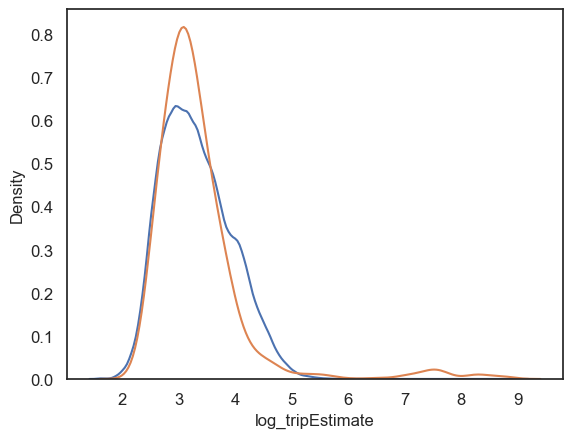

In [126]:
sns.kdeplot(data=bookings[bookings["CrossState"]==0],
            x="log_tripEstimate")
sns.kdeplot(data=bookings[bookings["CrossState"]==1],
            x="log_tripEstimate")
plt.show()

### 3.2.1 日内周期性
#### 估计价格（非聚类规律）

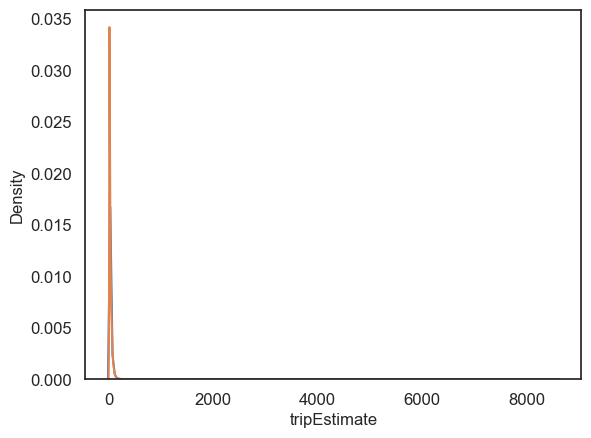

In [127]:
sns.kdeplot(data=bookings[bookings["DispatchStatus"]==0],
            x="tripEstimate")
sns.kdeplot(data=bookings[bookings["DispatchStatus"]==1],
            x="tripEstimate")
plt.show()

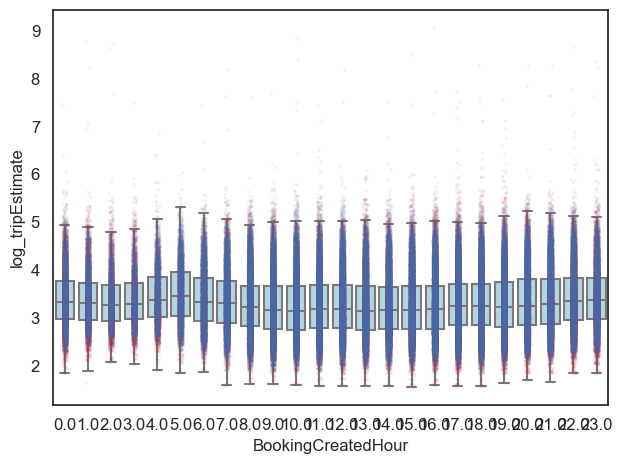

In [128]:
sns.boxplot(data=bookings,
            x="BookingCreatedHour",
            y="log_tripEstimate", color="lightblue",
            showfliers=False)
sns.stripplot(data=bookings[bookings["DispatchStatus"]==0],
              x="BookingCreatedHour",
              y="log_tripEstimate", size=2, linewidth=0,color="red",
              alpha=0.08)
sns.stripplot(data=bookings[bookings["DispatchStatus"]==1],
              x="BookingCreatedHour",
              y="log_tripEstimate", size=2, linewidth=0,color="b",
              alpha=0.08)

# plt.ylim(-10, 200)
plt.tight_layout()
plt.show()

In [129]:
whole[(whole["tripEstimate"] > 5000) & (whole["DispatchStatus"]==0)]

,partitionKey,user_pseudo_id,createdAt,startAddress,endAddress,tripEstimate,BookingID,BookingCreatedTime,PickUp_Latitude,PickUp_Longitude,...,DispatchStatus,StartState,EndState,CrossState,BookingCreatedHour,BookingCreatedMin,BookingCreatedDay,BookingCreatedDate,BookingCreatedWeek,BookingCreatedAdd
977563,7f4b0990-4760-11ed-9661-47dabcf94230,E337EA5FD4DB49C69882FDBEF2CD12FB,2022-10-09 10:25:29.640,"166 Adelaide Terrace, Perth WA 6004, Australia","5 Arrival Dr, Tullamarine VIC 3045, Australia",6804.74,32211141.0,2022-10-09 10:25:37.126,-31.959202,115.871448,...,0.0,WA,VIC,1,10.0,25.0,6.0,2022-10-09,5.0,10.0
982063,e0aedc60-4536-11ed-9661-47dabcf94230,ac173263661ea29de81b887601bb59f1,2022-10-06 16:22:32.253,"152 James St, New Farm QLD 4005, Australia","4 Sargent St, New Farm QLD 4005, Australia",8602.65,32142538.0,2022-10-06 16:22:37.856,-27.461591,153.046539,...,0.0,QLD,QLD,0,16.0,22.0,3.0,2022-10-06,5.0,16.0
984109,656951f0-585c-11ed-ab27-35d86fd49d36,870751a9948227bde157a36e495a9dc7,2022-10-31 01:08:58.000,"100 Millot Vista, Caversham WA 6055, Australia","22 Monash St, Newstead VIC 3462, Australia",6582.45,32750731.0,2022-10-31 01:14:07.000,-31.864053,115.968607,...,0.0,WA,VIC,1,1.0,14.0,0.0,2022-10-31,9.0,1.0
984278,5b20ee00-36a2-11ed-9992-2bb9650dd4cf,F7BA7D3D15244D8695A1DB9E51513EAC,2022-09-18 02:04:05.983,"2 Chelsea Cres, Glenella QLD 4740, Australia","3 Tamlyn Ct, Greenwith SA 5125, Australia",5717.25,31728575.0,2022-09-18 02:04:16.330,-21.110672,149.149613,...,0.0,QLD,SA,1,2.0,4.0,6.0,2022-09-18,2.0,2.0
985268,8cda22f0-4e11-11ed-9661-47dabcf94230,7F9325779B1644B498465285B7E9292B,2022-10-17 22:48:00.286,"387-389 Pacific Hwy, Crows Nest NSW 2065, Australia","31-45 Eyre St, North Ward QLD 4810, Australia",5746.34,32414329.0,2022-10-17 22:48:19.910,-33.829077,151.201875,...,0.0,NSW,QLD,1,22.0,48.0,0.0,2022-10-17,7.0,22.5
985473,d4ca9a50-2ba1-11ed-9a00-d5b713a64e81,24f001c8bdd712f5f6de682e2eac541d,2022-09-04 02:02:37.813,"7 The Strand, Townsville QLD 4810, Australia","3/10 Gawler St, Mount Barker SA 5251, Australia",6311.03,31405596.0,2022-09-04 02:02:40.423,-19.256865,146.824053,...,0.0,QLD,SA,1,2.0,2.0,6.0,2022-09-04,0.0,2.0


#### 总订单数（聚类规律）

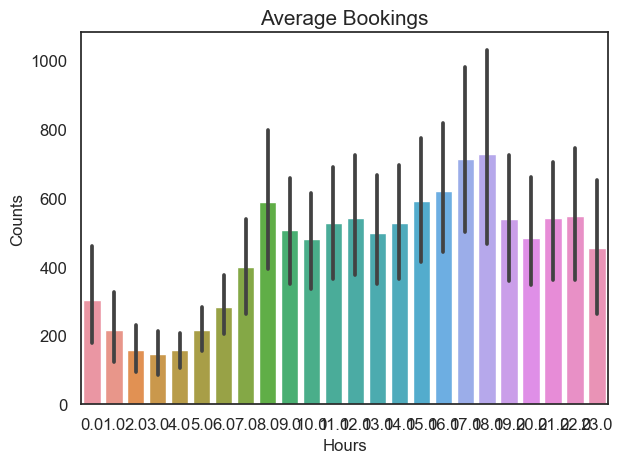

In [82]:
sns.barplot(data=gb,
             x="BookingCreatedHour",
             y="Counts",
             )
plt.ylabel("Counts")
plt.xlabel("Hours")
plt.title("Average Bookings")
plt.tight_layout()
plt.show()

#### 完成单数（聚类规则）

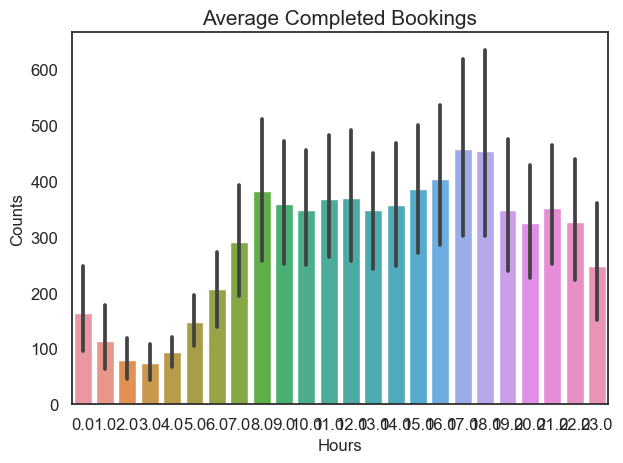

In [83]:
sns.barplot(data=gb,
             x="BookingCreatedHour",
             y="DispatchStatus",
             )
plt.ylabel("Counts")
plt.xlabel("Hours")
plt.title("Average Completed Bookings")
plt.tight_layout()
plt.show()

#### 完成单率（聚类规律）

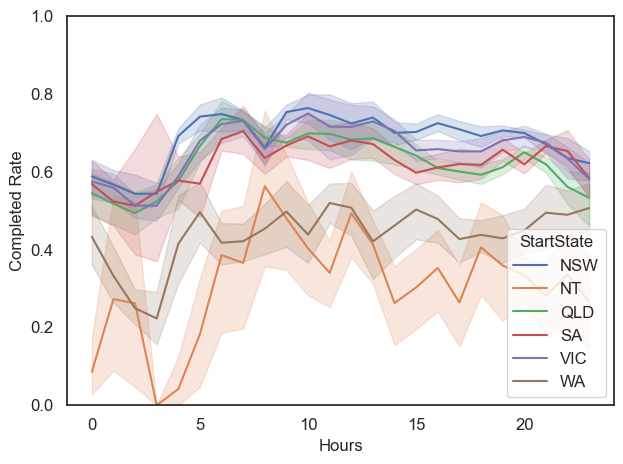

In [132]:
sns.lineplot(data=gb,
             x="BookingCreatedHour",
             y="Rate",
             hue="StartState"
             )
plt.ylabel("Completed Rate")
plt.xlabel("Hours")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

### 3.2.2 周周期性

#### 估计价格（非聚类规律）

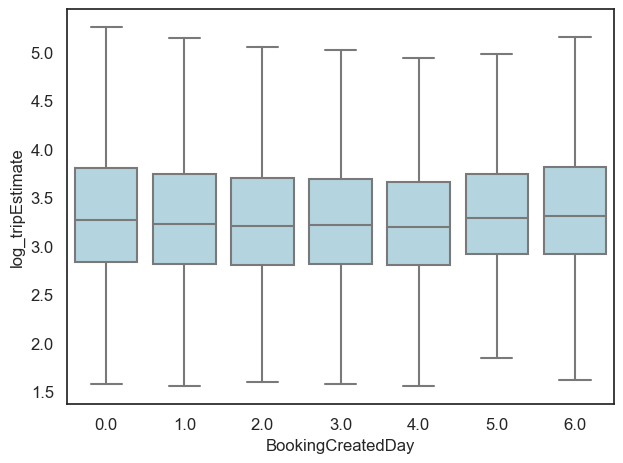

In [85]:
sns.boxplot(data=bookings,
            x="BookingCreatedDay",
            y="log_tripEstimate", color="lightblue",
            showfliers=False)
# sns.stripplot(data=bookings[bookings["DispatchStatus"]==0],
#               x="BookingCreatedHour",
#               y="tripEstimate", size=2, linewidth=0,color="red",
#               alpha=0.08)
# sns.stripplot(data=bookings[bookings["DispatchStatus"]==1],
#               x="BookingCreatedHour",
#               y="tripEstimate", size=2, linewidth=0,color="b",
#               alpha=0.08)

# plt.ylim(-10, 200)
plt.tight_layout()
plt.show()

#### 总订单数（聚类规律）

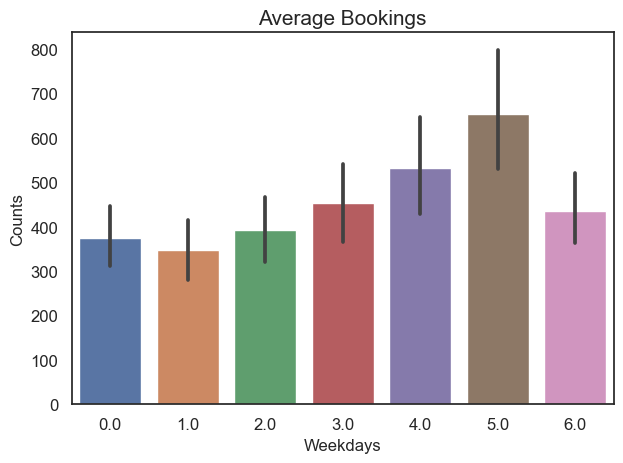

In [86]:
sns.barplot(data=gb,
             x="BookingCreatedDay",
             y="Counts",
             )
plt.ylabel("Counts")
plt.xlabel("Weekdays")
plt.title("Average Bookings")
plt.tight_layout()
plt.show()

#### 完成单数（聚类规律）

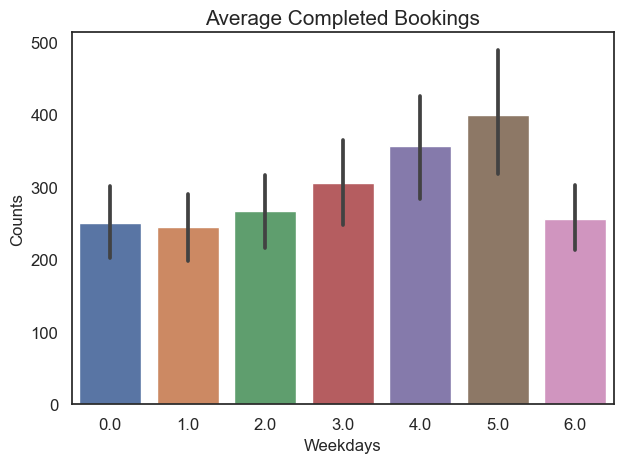

In [87]:
sns.barplot(data=gb,
             x="BookingCreatedDay",
             y="DispatchStatus",
             )
plt.ylabel("Counts")
plt.xlabel("Weekdays")
plt.title("Average Completed Bookings")
plt.tight_layout()
plt.show()

#### 完成单率（聚类规律）

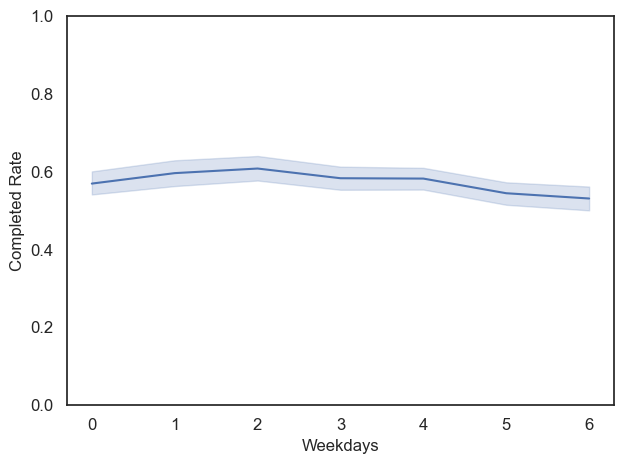

In [88]:
sns.lineplot(data=gb,
             x="BookingCreatedDay",
             y="Rate",
             )
plt.ylabel("Completed Rate")
plt.xlabel("Weekdays")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

## 3.3 用户类

### 3.3.1 近7日查询次数

In [89]:
whole["CompletedValue"] = whole["tripEstimate"] * whole["DispatchStatus"]

In [90]:
columns = ["partitionKey", "createdAt", "user_pseudo_id", "BookingID", "DispatchStatus", "CompletedValue"]
rolling = whole[columns].sort_values("createdAt",ascending=True).groupby(["user_pseudo_id"]).rolling(window="7D", on="createdAt", closed="left")
aggregate = pd.DataFrame()
aggregate[["LookingUpCounts_past7D","BookingCounts_past7D"]] = rolling.count()[["partitionKey","BookingID"]]
aggregate[["BookingCompleted_past7D", "CompletedValue_past7D"]] = rolling.sum()[["DispatchStatus","CompletedValue"]]
aggregate

LookingUpCounts_past7D  \
user_pseudo_id                                                     
000007C65F114B2594E6A2126765A295 626649                      NaN   
                                 14922                       1.0   
                                 916199                      NaN   
                                 1063582                     1.0   
                                 863637                      2.0   
...                                                          ...   
ffff96013007c74dca8b111fdba920c9 836676                      2.0   
                                 1055165                     3.0   
                                 853212                      2.0   
                                 835836                      2.0   
                                 837191                      NaN   

                                          BookingCounts_past7D  \
user_pseudo_id                                                   
000007C65F114B2594E6A2126765A295 626649                    NaN   
                                 14922                     0.0   
                                 916199                    NaN   
                                 1063582                   1.0   
                                 863637                    2.0   
...                                                        ...   
ffff96013007c74dca8b111fdba920c9 836676                    1.0   
                                 1055165                   2.0   
                                 853212                    2.0   
                                 835836                    2.0   
                                 837191                    NaN   

                                          BookingCompleted_past7D  \
user_pseudo_id                                                      
000007C65F114B2594E6A2126765A295 626649                       NaN   
                                 14922                        NaN   
                                 916199                       NaN   
                                 1063582                      1.0   
                                 863637                       1.0   
...                                                           ...   
ffff96013007c74dca8b111fdba920c9 836676                       0.0   
                                 1055165                      1.0   
                                 853212                       1.0   
                                 835836                       1.0   
                                 837191                       NaN   

                                          CompletedValue_past7D  
user_pseudo_id                                                   
000007C65F114B2594E6A2126765A295 626649                     NaN  
                                 14922                      NaN  
                                 916199                     NaN  
                                 1063582                  13.34  
                                 863637                   13.34  
...                                                         ...  
ffff96013007c74dca8b111fdba920c9 836676                    0.00  
                                 1055165                  23.84  
                                 853212                   23.84  
                                 835836                   23.63  
                                 837191                     NaN  

[1151919 rows x 4 columns]

In [91]:
agg = aggregate.reset_index(level=0).fillna(0)
agg

,user_pseudo_id,LookingUpCounts_past7D,BookingCounts_past7D,BookingCompleted_past7D,CompletedValue_past7D
626649,000007C65F114B2594E6A2126765A295,0.0,0.0,0.0,0.00
14922,000007C65F114B2594E6A2126765A295,1.0,0.0,0.0,0.00
916199,000007C65F114B2594E6A2126765A295,0.0,0.0,0.0,0.00
1063582,000007C65F114B2594E6A2126765A295,1.0,1.0,1.0,13.34
863637,000007C65F114B2594E6A2126765A295,2.0,2.0,1.0,13.34
...,...,...,...,...,...
836676,ffff96013007c74dca8b111fdba920c9,2.0,1.0,0.0,0.00
1055165,ffff96013007c74dca8b111fdba920c9,3.0,2.0,1.0,23.84
853212,ffff96013007c74dca8b111fdba920c9,2.0,2.0,1.0,23.84
835836,ffff96013007c74dca8b111fdba920c9,2.0,2.0,1.0,23.63


In [92]:
new = pd.merge(whole, agg, how="left", left_index=True, right_index=True)
new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151919 entries, 0 to 1153632
Data columns (total 30 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   partitionKey             1151919 non-null  object        
 1   user_pseudo_id_x         1151919 non-null  object        
 2   createdAt                1151919 non-null  datetime64[ns]
 3   startAddress             1151919 non-null  object        
 4   endAddress               1151919 non-null  object        
 5   tripEstimate             1151919 non-null  float64       
 6   BookingID                519835 non-null   float64       
 7   BookingCreatedTime       519835 non-null   datetime64[ns]
 8   PickUp_Latitude          519835 non-null   float64       
 9   PickUp_Longitude         519835 non-null   float64       
 10  DropOff_Latitude         519835 non-null   float64       
 11  DropOff_Longitude        519835 non-null   float64       
 12  

In [151]:
demo["BookingCompletedBins"] = demo["BookingCompleted_past7D"].apply(lambda x: x if x<=20 else 11)

In [179]:
demo["BookingCompletedRate_past7D"] = demo["BookingCompleted_past7D"] / demo["BookingCounts_past7D"]

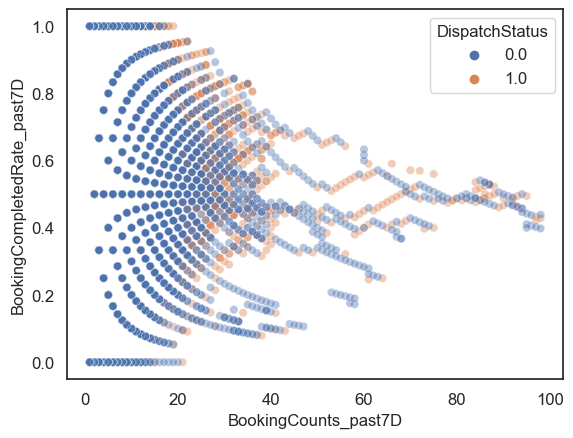

In [339]:
sns.scatterplot(data=demo,
                y="BookingCompletedRate_past7D",
                x="BookingCounts_past7D",
                hue="DispatchStatus",
                alpha=0.4)
plt.show()

In [161]:
df = demo.groupby(["BookingCompleted_past7D", "BookingCreatedHour", "StartState"]).sum()["DispatchStatus"].reset_index()
df["BookingCounts"] = demo.groupby(["BookingCompleted_past7D", "BookingCreatedHour", "StartState"]).count()["DispatchStatus"].reset_index()["DispatchStatus"]
df["Rate"] = df["DispatchStatus"] / df["BookingCounts"]
df

,BookingCompleted_past7D,BookingCreatedHour,StartState,DispatchStatus,BookingCounts,Rate
0,0.0,0.0,Coral Sea,7.0,7,1.000000
1,0.0,0.0,NSW,1240.0,2312,0.536332
2,0.0,0.0,NT,3.0,33,0.090909
3,0.0,0.0,QLD,1423.0,3026,0.470258
4,0.0,0.0,SA,139.0,247,0.562753
...,...,...,...,...,...,...
2237,46.0,3.0,VIC,1.0,3,0.333333
2238,46.0,14.0,VIC,1.0,1,1.000000
2239,46.0,22.0,VIC,1.0,1,1.000000
2240,46.0,23.0,VIC,0.0,1,0.000000


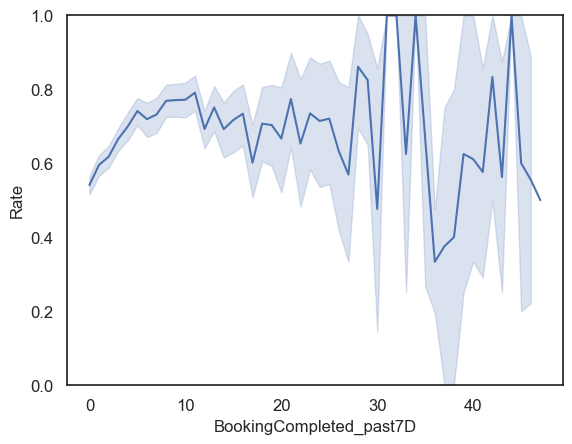

In [162]:
sns.lineplot(data=df,
             x="BookingCompleted_past7D",
             y="Rate",

)
plt.ylim(0,1)
plt.show()

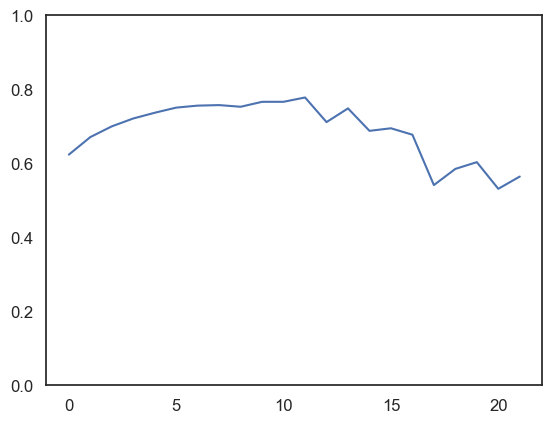

In [142]:
df = demo[["BookingCompletedBins", "DispatchStatus"]].groupby("BookingCompletedBins").sum() / demo[["BookingCompletedBins", "DispatchStatus"]].groupby("BookingCompletedBins").count()
plt.plot(df["DispatchStatus"].values)
plt.ylim(0,1)
plt.show()


### 3.3.2 近7日预订次数

### 3.3.3 近7日预订完成率